In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

InterruptException: InterruptException:

In [5]:
function r(s)
    range = s[1]
    if range > 150 return -.3 end  # reward to not lose track of contact
    if range <= 10 return -20 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [6]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [7]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [8]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [9]:

N = 400
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.25
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 5000
epochsize = 100

total = 0
rando = 0

last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current4_6.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 4.5 AVG: 5.75 Epoch: 43 -----------
--------- CURRENT: 46.0 AVG: 6.644 Epoch: 44 -----------
--------- CURRENT: 50.0 AVG: 7.587 Epoch: 45 -----------
--------- CURRENT: 50.0 AVG: 8.489 Epoch: 46 -----------
--------- CURRENT: 50.0 AVG: 9.354 Epoch: 47 -----------
--------- CURRENT: -553.0 AVG: -2.122 Epoch: 48 -----------
--------- CURRENT: 42.0 AVG: -1.24 Epoch: 49 -----------
--------- CURRENT: 4.0 AVG: -1.137 Epoch: 50 -----------
--------- CURRENT: 50.0 AVG: -0.1538 Epoch: 51 -----------
--------- CURRENT: 50.0 AVG: 0.7925 Epoch: 52 -----------
--------- CURRENT: 50.0 AVG: 1.704 Epoch: 53 -----------
--------- CURRENT: 50.0 AVG: 2.582 Epoch: 54 -----------
--------- CURRENT: 38.0 AVG: 3.214 Epoch: 55 -----------
--------- CURRENT: 50.0 AVG: 4.035 Epoch: 56 -----------
--------- CURRENT: 44.0 AVG: 4.724 Epoch: 57 -----------
--------- CURRENT: 20.0 AVG: 4.983 Epoch: 58 -----------
--------- CURRENT: 50.0 AVG: 5.733 Epoch: 59 -----------
--------- CURRENT: 50.0 AVG

--------- CURRENT: 50.0 AVG: -29.67 Epoch: 184 -----------
--------- CURRENT: 50.0 AVG: -29.24 Epoch: 185 -----------
--------- CURRENT: 50.0 AVG: -28.82 Epoch: 186 -----------
--------- CURRENT: 50.0 AVG: -28.4 Epoch: 187 -----------
--------- CURRENT: 18.0 AVG: -28.15 Epoch: 188 -----------
--------- CURRENT: -74.0 AVG: -28.39 Epoch: 189 -----------
--------- CURRENT: 50.0 AVG: -27.98 Epoch: 190 -----------
--------- CURRENT: -62.0 AVG: -28.16 Epoch: 191 -----------
--------- CURRENT: 50.0 AVG: -27.76 Epoch: 192 -----------
--------- CURRENT: 34.0 AVG: -27.44 Epoch: 193 -----------
--------- CURRENT: -251.5 AVG: -28.59 Epoch: 194 -----------
--------- CURRENT: 44.0 AVG: -28.22 Epoch: 195 -----------
--------- CURRENT: 38.0 AVG: -27.88 Epoch: 196 -----------
--------- CURRENT: 50.0 AVG: -27.49 Epoch: 197 -----------
--------- CURRENT: -6.0 AVG: -27.38 Epoch: 198 -----------
--------- CURRENT: -38.0 AVG: -27.43 Epoch: 199 -----------
--------- CURRENT: 50.0 AVG: -27.05 Epoch: 200 -----

--------- CURRENT: 50.0 AVG: -19.35 Epoch: 323 -----------
--------- CURRENT: 50.0 AVG: -19.14 Epoch: 324 -----------
--------- CURRENT: 36.0 AVG: -18.97 Epoch: 325 -----------
--------- CURRENT: 38.0 AVG: -18.8 Epoch: 326 -----------
--------- CURRENT: 50.0 AVG: -18.59 Epoch: 327 -----------
--------- CURRENT: 46.0 AVG: -18.39 Epoch: 328 -----------
--------- CURRENT: 50.0 AVG: -18.18 Epoch: 329 -----------
--------- CURRENT: 50.0 AVG: -17.98 Epoch: 330 -----------
--------- CURRENT: -24.0 AVG: -18.0 Epoch: 331 -----------
--------- CURRENT: 50.0 AVG: -17.79 Epoch: 332 -----------
--------- CURRENT: 50.0 AVG: -17.59 Epoch: 333 -----------
--------- CURRENT: 50.0 AVG: -17.39 Epoch: 334 -----------
--------- CURRENT: 42.0 AVG: -17.21 Epoch: 335 -----------
--------- CURRENT: -6.0 AVG: -17.18 Epoch: 336 -----------
--------- CURRENT: -52.0 AVG: -17.28 Epoch: 337 -----------
--------- CURRENT: 50.0 AVG: -17.08 Epoch: 338 -----------
--------- CURRENT: 50.0 AVG: -16.88 Epoch: 339 ---------

--------- CURRENT: 16.0 AVG: -20.37 Epoch: 462 -----------
--------- CURRENT: 50.0 AVG: -20.21 Epoch: 463 -----------
--------- CURRENT: 50.0 AVG: -20.06 Epoch: 464 -----------
--------- CURRENT: 50.0 AVG: -19.91 Epoch: 465 -----------
--------- CURRENT: 50.0 AVG: -19.76 Epoch: 466 -----------
--------- CURRENT: 50.0 AVG: -19.61 Epoch: 467 -----------
--------- CURRENT: 50.0 AVG: -19.47 Epoch: 468 -----------
--------- CURRENT: -78.0 AVG: -19.59 Epoch: 469 -----------
--------- CURRENT: 50.0 AVG: -19.44 Epoch: 470 -----------
--------- CURRENT: -653.5 AVG: -20.79 Epoch: 471 -----------
--------- CURRENT: -754.0 AVG: -22.34 Epoch: 472 -----------
--------- CURRENT: 50.0 AVG: -22.18 Epoch: 473 -----------
--------- CURRENT: 50.0 AVG: -22.03 Epoch: 474 -----------
--------- CURRENT: -1960.0 AVG: -26.1 Epoch: 475 -----------
--------- CURRENT: 50.0 AVG: -25.94 Epoch: 476 -----------
--------- CURRENT: 16.0 AVG: -25.86 Epoch: 477 -----------
--------- CURRENT: 50.0 AVG: -25.7 Epoch: 478 ---

--------- CURRENT: -754.0 AVG: -41.43 Epoch: 601 -----------
--------- CURRENT: 50.0 AVG: -41.28 Epoch: 602 -----------
--------- CURRENT: 50.0 AVG: -41.13 Epoch: 603 -----------
--------- CURRENT: 50.0 AVG: -40.98 Epoch: 604 -----------
--------- CURRENT: 50.0 AVG: -40.83 Epoch: 605 -----------
--------- CURRENT: 50.0 AVG: -40.68 Epoch: 606 -----------
--------- CURRENT: 50.0 AVG: -40.53 Epoch: 607 -----------
--------- CURRENT: 50.0 AVG: -40.38 Epoch: 608 -----------
--------- CURRENT: 50.0 AVG: -40.23 Epoch: 609 -----------
--------- CURRENT: 50.0 AVG: -40.08 Epoch: 610 -----------
--------- CURRENT: 50.0 AVG: -39.94 Epoch: 611 -----------
--------- CURRENT: 50.0 AVG: -39.79 Epoch: 612 -----------
--------- CURRENT: 24.0 AVG: -39.69 Epoch: 613 -----------
--------- CURRENT: 50.0 AVG: -39.54 Epoch: 614 -----------
--------- CURRENT: 50.0 AVG: -39.4 Epoch: 615 -----------
--------- CURRENT: 50.0 AVG: -39.25 Epoch: 616 -----------
--------- CURRENT: 2.0 AVG: -39.18 Epoch: 617 ---------

--------- CURRENT: 50.0 AVG: -44.72 Epoch: 740 -----------
--------- CURRENT: 50.0 AVG: -44.59 Epoch: 741 -----------
--------- CURRENT: -110.0 AVG: -44.68 Epoch: 742 -----------
--------- CURRENT: 50.0 AVG: -44.55 Epoch: 743 -----------
--------- CURRENT: -34.0 AVG: -44.54 Epoch: 744 -----------
--------- CURRENT: 50.0 AVG: -44.41 Epoch: 745 -----------
--------- CURRENT: 50.0 AVG: -44.28 Epoch: 746 -----------
--------- CURRENT: 50.0 AVG: -44.16 Epoch: 747 -----------
--------- CURRENT: 50.0 AVG: -44.03 Epoch: 748 -----------
--------- CURRENT: 50.0 AVG: -43.91 Epoch: 749 -----------
--------- CURRENT: 50.0 AVG: -43.78 Epoch: 750 -----------
--------- CURRENT: 50.0 AVG: -43.66 Epoch: 751 -----------
--------- CURRENT: 50.0 AVG: -43.53 Epoch: 752 -----------
--------- CURRENT: -1357.0 AVG: -45.28 Epoch: 753 -----------
--------- CURRENT: 50.0 AVG: -45.15 Epoch: 754 -----------
--------- CURRENT: 50.0 AVG: -45.02 Epoch: 755 -----------
--------- CURRENT: 50.0 AVG: -44.9 Epoch: 756 ----

--------- CURRENT: 50.0 AVG: -44.05 Epoch: 879 -----------
--------- CURRENT: 50.0 AVG: -43.94 Epoch: 880 -----------
--------- CURRENT: 50.0 AVG: -43.84 Epoch: 881 -----------
--------- CURRENT: -78.0 AVG: -43.88 Epoch: 882 -----------
--------- CURRENT: 50.0 AVG: -43.77 Epoch: 883 -----------
--------- CURRENT: 50.0 AVG: -43.66 Epoch: 884 -----------
--------- CURRENT: 50.0 AVG: -43.56 Epoch: 885 -----------
--------- CURRENT: 50.0 AVG: -43.45 Epoch: 886 -----------
--------- CURRENT: 32.0 AVG: -43.37 Epoch: 887 -----------
--------- CURRENT: 50.0 AVG: -43.26 Epoch: 888 -----------
--------- CURRENT: 50.0 AVG: -43.16 Epoch: 889 -----------
--------- CURRENT: 50.0 AVG: -43.05 Epoch: 890 -----------
--------- CURRENT: 50.0 AVG: -42.95 Epoch: 891 -----------
--------- CURRENT: 50.0 AVG: -42.84 Epoch: 892 -----------
--------- CURRENT: 50.0 AVG: -42.74 Epoch: 893 -----------
--------- CURRENT: -26.0 AVG: -42.72 Epoch: 894 -----------
--------- CURRENT: 36.0 AVG: -42.63 Epoch: 895 -------

--------- CURRENT: 50.0 AVG: -39.39 Epoch: 1017 -----------
--------- CURRENT: 50.0 AVG: -39.31 Epoch: 1018 -----------
--------- CURRENT: 50.0 AVG: -39.22 Epoch: 1019 -----------
--------- CURRENT: 50.0 AVG: -39.13 Epoch: 1020 -----------
--------- CURRENT: 50.0 AVG: -39.04 Epoch: 1021 -----------
--------- CURRENT: 50.0 AVG: -38.96 Epoch: 1022 -----------
--------- CURRENT: -66.0 AVG: -38.98 Epoch: 1023 -----------
--------- CURRENT: 50.0 AVG: -38.9 Epoch: 1024 -----------
--------- CURRENT: -104.0 AVG: -38.96 Epoch: 1025 -----------
--------- CURRENT: 50.0 AVG: -38.87 Epoch: 1026 -----------
--------- CURRENT: 50.0 AVG: -38.79 Epoch: 1027 -----------
--------- CURRENT: -76.0 AVG: -38.82 Epoch: 1028 -----------
--------- CURRENT: -754.0 AVG: -39.52 Epoch: 1029 -----------
--------- CURRENT: 50.0 AVG: -39.43 Epoch: 1030 -----------
--------- CURRENT: -78.0 AVG: -39.47 Epoch: 1031 -----------
--------- CURRENT: 50.0 AVG: -39.38 Epoch: 1032 -----------
--------- CURRENT: 50.0 AVG: -39.3

--------- CURRENT: -754.0 AVG: -35.25 Epoch: 1154 -----------
--------- CURRENT: 50.0 AVG: -35.18 Epoch: 1155 -----------
--------- CURRENT: 50.0 AVG: -35.1 Epoch: 1156 -----------
--------- CURRENT: -352.0 AVG: -35.38 Epoch: 1157 -----------
--------- CURRENT: 50.0 AVG: -35.3 Epoch: 1158 -----------
--------- CURRENT: 50.0 AVG: -35.23 Epoch: 1159 -----------
--------- CURRENT: 50.0 AVG: -35.16 Epoch: 1160 -----------
--------- CURRENT: 50.0 AVG: -35.08 Epoch: 1161 -----------
--------- CURRENT: 50.0 AVG: -35.01 Epoch: 1162 -----------
--------- CURRENT: -1056.0 AVG: -35.89 Epoch: 1163 -----------
--------- CURRENT: 50.0 AVG: -35.81 Epoch: 1164 -----------
--------- CURRENT: 50.0 AVG: -35.74 Epoch: 1165 -----------
--------- CURRENT: 50.0 AVG: -35.67 Epoch: 1166 -----------
--------- CURRENT: 50.0 AVG: -35.59 Epoch: 1167 -----------
--------- CURRENT: 50.0 AVG: -35.52 Epoch: 1168 -----------
--------- CURRENT: 50.0 AVG: -35.45 Epoch: 1169 -----------
--------- CURRENT: 50.0 AVG: -35.37

--------- CURRENT: 50.0 AVG: -32.21 Epoch: 1291 -----------
--------- CURRENT: 50.0 AVG: -32.15 Epoch: 1292 -----------
--------- CURRENT: 50.0 AVG: -32.08 Epoch: 1293 -----------
--------- CURRENT: 50.0 AVG: -32.02 Epoch: 1294 -----------
--------- CURRENT: 50.0 AVG: -31.96 Epoch: 1295 -----------
--------- CURRENT: 50.0 AVG: -31.89 Epoch: 1296 -----------
--------- CURRENT: 50.0 AVG: -31.83 Epoch: 1297 -----------
--------- CURRENT: 50.0 AVG: -31.77 Epoch: 1298 -----------
--------- CURRENT: 50.0 AVG: -31.7 Epoch: 1299 -----------
--------- CURRENT: 50.0 AVG: -31.64 Epoch: 1300 -----------
--------- CURRENT: 50.0 AVG: -31.58 Epoch: 1301 -----------
--------- CURRENT: 50.0 AVG: -31.52 Epoch: 1302 -----------
--------- CURRENT: 50.0 AVG: -31.45 Epoch: 1303 -----------
--------- CURRENT: 50.0 AVG: -31.39 Epoch: 1304 -----------
--------- CURRENT: 50.0 AVG: -31.33 Epoch: 1305 -----------
--------- CURRENT: 50.0 AVG: -31.27 Epoch: 1306 -----------
--------- CURRENT: 50.0 AVG: -31.2 Epoch:

--------- CURRENT: 50.0 AVG: -31.41 Epoch: 1428 -----------
--------- CURRENT: 50.0 AVG: -31.35 Epoch: 1429 -----------
--------- CURRENT: 50.0 AVG: -31.29 Epoch: 1430 -----------
--------- CURRENT: -18.0 AVG: -31.28 Epoch: 1431 -----------
--------- CURRENT: 50.0 AVG: -31.23 Epoch: 1432 -----------
--------- CURRENT: -146.0 AVG: -31.31 Epoch: 1433 -----------
--------- CURRENT: 50.0 AVG: -31.25 Epoch: 1434 -----------
--------- CURRENT: 50.0 AVG: -31.19 Epoch: 1435 -----------
--------- CURRENT: 50.0 AVG: -31.14 Epoch: 1436 -----------
--------- CURRENT: 50.0 AVG: -31.08 Epoch: 1437 -----------
--------- CURRENT: 50.0 AVG: -31.02 Epoch: 1438 -----------
--------- CURRENT: 50.0 AVG: -30.97 Epoch: 1439 -----------
--------- CURRENT: 50.0 AVG: -30.91 Epoch: 1440 -----------
--------- CURRENT: 50.0 AVG: -30.86 Epoch: 1441 -----------
--------- CURRENT: -151.0 AVG: -30.94 Epoch: 1442 -----------
--------- CURRENT: 50.0 AVG: -30.88 Epoch: 1443 -----------
--------- CURRENT: 50.0 AVG: -30.83

--------- CURRENT: 50.0 AVG: -26.5 Epoch: 1565 -----------
--------- CURRENT: 26.0 AVG: -26.47 Epoch: 1566 -----------
--------- CURRENT: 50.0 AVG: -26.42 Epoch: 1567 -----------
--------- CURRENT: 50.0 AVG: -26.37 Epoch: 1568 -----------
--------- CURRENT: 50.0 AVG: -26.32 Epoch: 1569 -----------
--------- CURRENT: 50.0 AVG: -26.28 Epoch: 1570 -----------
--------- CURRENT: 50.0 AVG: -26.23 Epoch: 1571 -----------
--------- CURRENT: 50.0 AVG: -26.18 Epoch: 1572 -----------
--------- CURRENT: 50.0 AVG: -26.13 Epoch: 1573 -----------
--------- CURRENT: -2362.0 AVG: -27.61 Epoch: 1574 -----------
--------- CURRENT: 50.0 AVG: -27.56 Epoch: 1575 -----------
--------- CURRENT: 50.0 AVG: -27.51 Epoch: 1576 -----------
--------- CURRENT: 50.0 AVG: -27.47 Epoch: 1577 -----------
--------- CURRENT: 50.0 AVG: -27.42 Epoch: 1578 -----------
--------- CURRENT: 50.0 AVG: -27.37 Epoch: 1579 -----------
--------- CURRENT: 50.0 AVG: -27.32 Epoch: 1580 -----------
--------- CURRENT: 50.0 AVG: -27.27 Ep

--------- CURRENT: 50.0 AVG: -30.2 Epoch: 1701 -----------
--------- CURRENT: 50.0 AVG: -30.15 Epoch: 1702 -----------
--------- CURRENT: -553.0 AVG: -30.46 Epoch: 1703 -----------
--------- CURRENT: 50.0 AVG: -30.41 Epoch: 1704 -----------
--------- CURRENT: 50.0 AVG: -30.36 Epoch: 1705 -----------
--------- CURRENT: 50.0 AVG: -30.32 Epoch: 1706 -----------
--------- CURRENT: 50.0 AVG: -30.27 Epoch: 1707 -----------
--------- CURRENT: 8.0 AVG: -30.25 Epoch: 1708 -----------
--------- CURRENT: -653.5 AVG: -30.61 Epoch: 1709 -----------
--------- CURRENT: 50.0 AVG: -30.56 Epoch: 1710 -----------
--------- CURRENT: 50.0 AVG: -30.52 Epoch: 1711 -----------
--------- CURRENT: 50.0 AVG: -30.47 Epoch: 1712 -----------
--------- CURRENT: 50.0 AVG: -30.42 Epoch: 1713 -----------
--------- CURRENT: 50.0 AVG: -30.38 Epoch: 1714 -----------
--------- CURRENT: 48.0 AVG: -30.33 Epoch: 1715 -----------
--------- CURRENT: 50.0 AVG: -30.28 Epoch: 1716 -----------
--------- CURRENT: 36.0 AVG: -30.24 Ep

--------- CURRENT: 50.0 AVG: -30.53 Epoch: 1837 -----------
--------- CURRENT: 50.0 AVG: -30.48 Epoch: 1838 -----------
--------- CURRENT: 50.0 AVG: -30.44 Epoch: 1839 -----------
--------- CURRENT: 50.0 AVG: -30.4 Epoch: 1840 -----------
--------- CURRENT: 50.0 AVG: -30.35 Epoch: 1841 -----------
--------- CURRENT: 50.0 AVG: -30.31 Epoch: 1842 -----------
--------- CURRENT: 50.0 AVG: -30.27 Epoch: 1843 -----------
--------- CURRENT: 50.0 AVG: -30.22 Epoch: 1844 -----------
--------- CURRENT: 50.0 AVG: -30.18 Epoch: 1845 -----------
--------- CURRENT: 16.0 AVG: -30.15 Epoch: 1846 -----------
--------- CURRENT: -1056.0 AVG: -30.71 Epoch: 1847 -----------
--------- CURRENT: -106.0 AVG: -30.75 Epoch: 1848 -----------
--------- CURRENT: 50.0 AVG: -30.71 Epoch: 1849 -----------
--------- CURRENT: 50.0 AVG: -30.66 Epoch: 1850 -----------
--------- CURRENT: 50.0 AVG: -30.62 Epoch: 1851 -----------
--------- CURRENT: 50.0 AVG: -30.58 Epoch: 1852 -----------
--------- CURRENT: 50.0 AVG: -30.53 

--------- CURRENT: 50.0 AVG: -28.13 Epoch: 1974 -----------
--------- CURRENT: 50.0 AVG: -28.09 Epoch: 1975 -----------
--------- CURRENT: 50.0 AVG: -28.05 Epoch: 1976 -----------
--------- CURRENT: 50.0 AVG: -28.01 Epoch: 1977 -----------
--------- CURRENT: 50.0 AVG: -27.97 Epoch: 1978 -----------
--------- CURRENT: 50.0 AVG: -27.93 Epoch: 1979 -----------
--------- CURRENT: 50.0 AVG: -27.89 Epoch: 1980 -----------
--------- CURRENT: 50.0 AVG: -27.85 Epoch: 1981 -----------
--------- CURRENT: 50.0 AVG: -27.81 Epoch: 1982 -----------
--------- CURRENT: 50.0 AVG: -27.77 Epoch: 1983 -----------
--------- CURRENT: 50.0 AVG: -27.73 Epoch: 1984 -----------
--------- CURRENT: 50.0 AVG: -27.69 Epoch: 1985 -----------
--------- CURRENT: 50.0 AVG: -27.65 Epoch: 1986 -----------
--------- CURRENT: 50.0 AVG: -27.61 Epoch: 1987 -----------
--------- CURRENT: 50.0 AVG: -27.58 Epoch: 1988 -----------
--------- CURRENT: 50.0 AVG: -27.54 Epoch: 1989 -----------
--------- CURRENT: 50.0 AVG: -27.5 Epoch

--------- CURRENT: 50.0 AVG: -27.29 Epoch: 2111 -----------
--------- CURRENT: -151.0 AVG: -27.35 Epoch: 2112 -----------
--------- CURRENT: 50.0 AVG: -27.31 Epoch: 2113 -----------
--------- CURRENT: 50.0 AVG: -27.27 Epoch: 2114 -----------
--------- CURRENT: 50.0 AVG: -27.24 Epoch: 2115 -----------
--------- CURRENT: 50.0 AVG: -27.2 Epoch: 2116 -----------
--------- CURRENT: 50.0 AVG: -27.16 Epoch: 2117 -----------
--------- CURRENT: 50.0 AVG: -27.13 Epoch: 2118 -----------
--------- CURRENT: 44.0 AVG: -27.09 Epoch: 2119 -----------
--------- CURRENT: 50.0 AVG: -27.06 Epoch: 2120 -----------
--------- CURRENT: 50.0 AVG: -27.02 Epoch: 2121 -----------
--------- CURRENT: 50.0 AVG: -26.98 Epoch: 2122 -----------
--------- CURRENT: 50.0 AVG: -26.95 Epoch: 2123 -----------
--------- CURRENT: 50.0 AVG: -26.91 Epoch: 2124 -----------
--------- CURRENT: 50.0 AVG: -26.87 Epoch: 2125 -----------
--------- CURRENT: 50.0 AVG: -26.84 Epoch: 2126 -----------
--------- CURRENT: 50.0 AVG: -26.8 Epoc

--------- CURRENT: 50.0 AVG: -28.0 Epoch: 2248 -----------
--------- CURRENT: 50.0 AVG: -27.96 Epoch: 2249 -----------
--------- CURRENT: 50.0 AVG: -27.93 Epoch: 2250 -----------
--------- CURRENT: 50.0 AVG: -27.89 Epoch: 2251 -----------
--------- CURRENT: 50.0 AVG: -27.86 Epoch: 2252 -----------
--------- CURRENT: 50.0 AVG: -27.83 Epoch: 2253 -----------
--------- CURRENT: 50.0 AVG: -27.79 Epoch: 2254 -----------
--------- CURRENT: 50.0 AVG: -27.76 Epoch: 2255 -----------
--------- CURRENT: 50.0 AVG: -27.72 Epoch: 2256 -----------
--------- CURRENT: 50.0 AVG: -27.69 Epoch: 2257 -----------
--------- CURRENT: 50.0 AVG: -27.65 Epoch: 2258 -----------
--------- CURRENT: 50.0 AVG: -27.62 Epoch: 2259 -----------
--------- CURRENT: 50.0 AVG: -27.58 Epoch: 2260 -----------
--------- CURRENT: 50.0 AVG: -27.55 Epoch: 2261 -----------
--------- CURRENT: -134.0 AVG: -27.6 Epoch: 2262 -----------
--------- CURRENT: 50.0 AVG: -27.56 Epoch: 2263 -----------
--------- CURRENT: 50.0 AVG: -27.53 Epoc

--------- CURRENT: 50.0 AVG: -27.33 Epoch: 2384 -----------
--------- CURRENT: 50.0 AVG: -27.29 Epoch: 2385 -----------
--------- CURRENT: 50.0 AVG: -27.26 Epoch: 2386 -----------
--------- CURRENT: 50.0 AVG: -27.23 Epoch: 2387 -----------
--------- CURRENT: 50.0 AVG: -27.2 Epoch: 2388 -----------
--------- CURRENT: 50.0 AVG: -27.17 Epoch: 2389 -----------
--------- CURRENT: 50.0 AVG: -27.13 Epoch: 2390 -----------
--------- CURRENT: 50.0 AVG: -27.1 Epoch: 2391 -----------
--------- CURRENT: 50.0 AVG: -27.07 Epoch: 2392 -----------
--------- CURRENT: 50.0 AVG: -27.04 Epoch: 2393 -----------
--------- CURRENT: -653.5 AVG: -27.3 Epoch: 2394 -----------
--------- CURRENT: 50.0 AVG: -27.27 Epoch: 2395 -----------
--------- CURRENT: 50.0 AVG: -27.23 Epoch: 2396 -----------
--------- CURRENT: -452.5 AVG: -27.41 Epoch: 2397 -----------
--------- CURRENT: 50.0 AVG: -27.38 Epoch: 2398 -----------
--------- CURRENT: 50.0 AVG: -27.35 Epoch: 2399 -----------
--------- CURRENT: -151.0 AVG: -27.4 Ep

--------- CURRENT: 50.0 AVG: -29.02 Epoch: 2521 -----------
--------- CURRENT: -1960.0 AVG: -29.79 Epoch: 2522 -----------
--------- CURRENT: 50.0 AVG: -29.76 Epoch: 2523 -----------
--------- CURRENT: -84.0 AVG: -29.78 Epoch: 2524 -----------
--------- CURRENT: 50.0 AVG: -29.75 Epoch: 2525 -----------
--------- CURRENT: 50.0 AVG: -29.71 Epoch: 2526 -----------
--------- CURRENT: 50.0 AVG: -29.68 Epoch: 2527 -----------
--------- CURRENT: 50.0 AVG: -29.65 Epoch: 2528 -----------
--------- CURRENT: 50.0 AVG: -29.62 Epoch: 2529 -----------
--------- CURRENT: 50.0 AVG: -29.59 Epoch: 2530 -----------
--------- CURRENT: 50.0 AVG: -29.56 Epoch: 2531 -----------
--------- CURRENT: 50.0 AVG: -29.53 Epoch: 2532 -----------
--------- CURRENT: -955.0 AVG: -29.89 Epoch: 2533 -----------
--------- CURRENT: 50.0 AVG: -29.86 Epoch: 2534 -----------
--------- CURRENT: 50.0 AVG: -29.83 Epoch: 2535 -----------
--------- CURRENT: 50.0 AVG: -29.8 Epoch: 2536 -----------
--------- CURRENT: 50.0 AVG: -29.77

--------- CURRENT: 50.0 AVG: -34.76 Epoch: 2780 -----------
--------- CURRENT: -78.0 AVG: -34.77 Epoch: 2781 -----------
--------- CURRENT: 34.0 AVG: -34.75 Epoch: 2782 -----------
--------- CURRENT: 50.0 AVG: -34.72 Epoch: 2783 -----------
--------- CURRENT: 50.0 AVG: -34.69 Epoch: 2784 -----------
--------- CURRENT: 46.0 AVG: -34.66 Epoch: 2785 -----------
--------- CURRENT: 50.0 AVG: -34.63 Epoch: 2786 -----------
--------- CURRENT: 50.0 AVG: -34.6 Epoch: 2787 -----------
--------- CURRENT: 50.0 AVG: -34.57 Epoch: 2788 -----------
--------- CURRENT: 50.0 AVG: -34.54 Epoch: 2789 -----------
--------- CURRENT: 50.0 AVG: -34.51 Epoch: 2790 -----------
--------- CURRENT: 50.0 AVG: -34.48 Epoch: 2791 -----------
--------- CURRENT: 50.0 AVG: -34.44 Epoch: 2792 -----------
--------- CURRENT: 50.0 AVG: -34.41 Epoch: 2793 -----------
--------- CURRENT: 50.0 AVG: -34.38 Epoch: 2794 -----------
--------- CURRENT: 50.0 AVG: -34.35 Epoch: 2795 -----------
--------- CURRENT: -16.0 AVG: -34.35 Epo

--------- CURRENT: 50.0 AVG: -41.84 Epoch: 3398 -----------
--------- CURRENT: 50.0 AVG: -41.82 Epoch: 3399 -----------
--------- CURRENT: 50.0 AVG: -41.79 Epoch: 3400 -----------
--------- CURRENT: 50.0 AVG: -41.76 Epoch: 3401 -----------
--------- CURRENT: 50.0 AVG: -41.74 Epoch: 3402 -----------
--------- CURRENT: -1960.0 AVG: -42.3 Epoch: 3403 -----------
--------- CURRENT: 50.0 AVG: -42.27 Epoch: 3404 -----------
--------- CURRENT: 50.0 AVG: -42.24 Epoch: 3405 -----------
--------- CURRENT: -144.0 AVG: -42.27 Epoch: 3406 -----------
--------- CURRENT: 50.0 AVG: -42.25 Epoch: 3407 -----------
--------- CURRENT: 50.0 AVG: -42.22 Epoch: 3408 -----------
--------- CURRENT: -116.0 AVG: -42.24 Epoch: 3409 -----------
--------- CURRENT: -754.0 AVG: -42.45 Epoch: 3410 -----------
--------- CURRENT: 50.0 AVG: -42.42 Epoch: 3411 -----------
--------- CURRENT: 50.0 AVG: -42.4 Epoch: 3412 -----------
--------- CURRENT: 36.0 AVG: -42.37 Epoch: 3413 -----------
--------- CURRENT: 50.0 AVG: -42.

--------- CURRENT: 50.0 AVG: -43.14 Epoch: 3677 -----------
--------- CURRENT: 50.0 AVG: -43.11 Epoch: 3678 -----------
--------- CURRENT: 50.0 AVG: -43.09 Epoch: 3679 -----------
--------- CURRENT: 50.0 AVG: -43.06 Epoch: 3680 -----------
--------- CURRENT: 50.0 AVG: -43.04 Epoch: 3681 -----------
--------- CURRENT: 50.0 AVG: -43.01 Epoch: 3682 -----------
--------- CURRENT: 50.0 AVG: -42.98 Epoch: 3683 -----------
--------- CURRENT: 50.0 AVG: -42.96 Epoch: 3684 -----------
--------- CURRENT: -653.5 AVG: -43.13 Epoch: 3685 -----------
--------- CURRENT: 50.0 AVG: -43.1 Epoch: 3686 -----------
--------- CURRENT: 50.0 AVG: -43.07 Epoch: 3687 -----------
--------- CURRENT: 50.0 AVG: -43.05 Epoch: 3688 -----------
--------- CURRENT: 50.0 AVG: -43.02 Epoch: 3689 -----------
--------- CURRENT: -452.5 AVG: -43.14 Epoch: 3690 -----------
--------- CURRENT: 50.0 AVG: -43.11 Epoch: 3691 -----------
--------- CURRENT: -150.0 AVG: -43.14 Epoch: 3692 -----------
--------- CURRENT: 50.0 AVG: -43.11

--------- CURRENT: 50.0 AVG: -43.31 Epoch: 3970 -----------
--------- CURRENT: 50.0 AVG: -43.28 Epoch: 3971 -----------
--------- CURRENT: 50.0 AVG: -43.26 Epoch: 3972 -----------
--------- CURRENT: 50.0 AVG: -43.24 Epoch: 3973 -----------
--------- CURRENT: 50.0 AVG: -43.21 Epoch: 3974 -----------
--------- CURRENT: 50.0 AVG: -43.19 Epoch: 3975 -----------
--------- CURRENT: 14.0 AVG: -43.18 Epoch: 3976 -----------
--------- CURRENT: 50.0 AVG: -43.15 Epoch: 3977 -----------
--------- CURRENT: 50.0 AVG: -43.13 Epoch: 3978 -----------
--------- CURRENT: 50.0 AVG: -43.11 Epoch: 3979 -----------
--------- CURRENT: 50.0 AVG: -43.08 Epoch: 3980 -----------
--------- CURRENT: 50.0 AVG: -43.06 Epoch: 3981 -----------
--------- CURRENT: 50.0 AVG: -43.04 Epoch: 3982 -----------
--------- CURRENT: 50.0 AVG: -43.01 Epoch: 3983 -----------
--------- CURRENT: 50.0 AVG: -42.99 Epoch: 3984 -----------
--------- CURRENT: 50.0 AVG: -42.97 Epoch: 3985 -----------
--------- CURRENT: 50.0 AVG: -42.94 Epoc

--------- CURRENT: -74.0 AVG: -44.58 Epoch: 4361 -----------
--------- CURRENT: 50.0 AVG: -44.56 Epoch: 4362 -----------
--------- CURRENT: -1458.0 AVG: -44.88 Epoch: 4363 -----------
--------- CURRENT: 50.0 AVG: -44.86 Epoch: 4364 -----------
--------- CURRENT: 50.0 AVG: -44.84 Epoch: 4365 -----------
--------- CURRENT: 50.0 AVG: -44.82 Epoch: 4366 -----------
--------- CURRENT: 44.0 AVG: -44.8 Epoch: 4367 -----------
--------- CURRENT: 50.0 AVG: -44.78 Epoch: 4368 -----------
--------- CURRENT: -151.0 AVG: -44.8 Epoch: 4369 -----------
--------- CURRENT: 50.0 AVG: -44.78 Epoch: 4370 -----------
--------- CURRENT: 50.0 AVG: -44.76 Epoch: 4371 -----------
--------- CURRENT: 46.0 AVG: -44.74 Epoch: 4372 -----------
--------- CURRENT: 50.0 AVG: -44.72 Epoch: 4373 -----------
--------- CURRENT: 50.0 AVG: -44.69 Epoch: 4374 -----------
--------- CURRENT: 44.0 AVG: -44.67 Epoch: 4375 -----------
--------- CURRENT: 50.0 AVG: -44.65 Epoch: 4376 -----------


In [17]:
#transpose(θ[:,2])*ξ

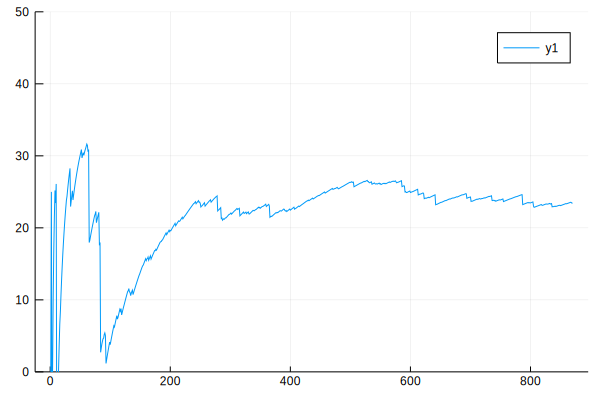

In [19]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

In [14]:
thetaframe = CSV.read("0.44_theta_12.1_1.csv")


,x1,x2,x3,x4,x5,x6
,Float64,Float64,Float64,Float64,Float64,Float64
1,-1.77704,0.0,-3.91139,0.0,-1.6716,0.0
2,0.104306,0.0,-0.277353,0.0,0.29317,0.0
3,0.0992801,0.0,2.52568,0.0,1.46481,0.0
4,0.892081,0.0,2.81689,0.0,1.36093,0.0
5,0.633067,0.0,0.479396,0.0,0.563874,0.0
6,1.14868,0.0,0.109032,0.0,0.678002,0.0
7,0.651611,0.0,-0.0357058,0.0,0.760664,0.0
8,1.14689,0.0,1.85016,0.0,0.111559,0.0
9,1.16463,0.0,0.581399,0.0,0.865836,0.0


In [18]:
θ = convert(Matrix, thetaframe)

28080×6 Array{Float64,2}:
 -1.77704    0.0  -3.91139    0.0  -1.6716    0.0
  0.104306   0.0  -0.277353   0.0   0.29317   0.0
  0.0992801  0.0   2.52568    0.0   1.46481   0.0
  0.892081   0.0   2.81689    0.0   1.36093   0.0
  0.633067   0.0   0.479396   0.0   0.563874  0.0
  1.14868    0.0   0.109032   0.0   0.678002  0.0
  0.651611   0.0  -0.0357058  0.0   0.760664  0.0
  1.14689    0.0   1.85016    0.0   0.111559  0.0
  1.16463    0.0   0.581399   0.0   0.865836  0.0
  1.1367     0.0   1.04617    0.0   1.66769   0.0
  0.345221   0.0   0.929168   0.0   0.788199  0.0
  0.681581   0.0   1.02612    0.0   0.704559  0.0
  0.978036   0.0   0.321273   0.0   1.28954   0.0
  ⋮                                           ⋮  
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0  

In [25]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

"0.44_theta_11.28_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5